In [2]:
import numpy
import cvxopt
from cvxopt import matrix

In [3]:
from cvxopt import matrix, mul, div, cos, sin, exp, sqrt
from cvxopt import blas, lapack, solvers
try: import pylab
except ImportError: pylab_installed = False
else: pylab_installed = True

In [4]:
# Basis functions are Gabor pulses:  for k = 0,...,K-1,
#
#     exp(-(t - k * tau)^2/sigma^2 ) * cos (l*omega0*t),  l = 0,...,L
#     exp(-(t - k * tau)^2/sigma^2 ) * sin (l*omega0*t),  l = 1,...,L

sigma = 0.05
tau = 0.002
omega0 = 5.0
K = 501
L = 30
N = 501       # number of samples of each signal in [0,1]

In [5]:
# Build dictionary matrix
ts = (1.0/N) * matrix(range(N), tc='d')
B = ts[:, K*[0]] - tau * matrix(range(K), (1,K), 'd')[N*[0],:]
B = exp(-(B/sigma)**2)
A = matrix(0.0, (N, K*(2*L+1)))

In [7]:
# First K columns are DC pulses for k = 0,...,K-1
A[:,:K] = B
for l in range(L):

    # Cosine pulses for omega = (l+1)*omega0 and k = 0,...,K-1.
    A[:, K+l*(2*K) : K+l*(2*K)+K] = mul(B, cos((l+1)*omega0*ts)[:, K*[0]])

    # Sine pulses for omega = (l+1)*omega0 and k = 0,...,K-1.
    A[:, K+l*(2*K)+K : K+(l+1)*(2*K)] = \
        mul(B, sin((l+1)*omega0*ts)[:,K*[0]])

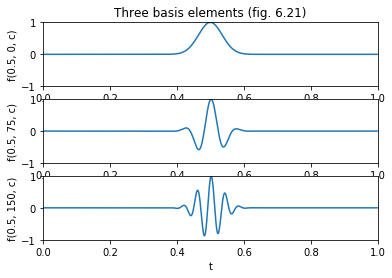

In [8]:
if pylab_installed:

    pylab.figure(1, facecolor='w')
    pylab.subplot(311)
    # DC pulse for k = 250 (tau = 0.5)
    pylab.plot(ts, A[:,250])
    pylab.ylabel('f(0.5, 0, c)')
    pylab.axis([0, 1, -1, 1])
    pylab.title('Three basis elements (fig. 6.21)')
    # Cosine pulse for k = 250 (tau = 0.5) and l = 15  (omega = 75)
    pylab.subplot(312)
    pylab.ylabel('f(0.5, 75, c)')
    pylab.plot(ts, A[:, K + 14*(2*K) + 250])
    pylab.axis([0, 1, -1, 1])
    pylab.subplot(313)
    # Cosine pulse for k = 250 (tau = 0.5) and l = 30  (omega = 150)
    pylab.plot(ts, A[:, K + 29*(2*K) + 250])
    pylab.ylabel('f(0.5, 150, c)')
    pylab.axis([0, 1, -1, 1])
    pylab.xlabel('t')

In [9]:
# Signal.
y = mul( 1.0 + 0.5 * sin(11*ts), sin(30 * sin(5*ts)))

In [10]:
# Basis pursuit problem
#
#     minimize    ||A*x - y||_2^2 + ||x||_1
#
#     minimize    x'*A'*A*x - 2.0*y'*A*x + 1'*u
#     subject to  -u <= x <= u
#
# Variables x (n),  u (n).

m, n = A.size
r = matrix(0.0, (m,1))

q = matrix(1.0, (2*n,1))
blas.gemv(A, y, q, alpha = -2.0, trans = 'T')

In [11]:
def P(u, v, alpha = 1.0, beta = 0.0):
    """
    Function and gradient evaluation of

        v := alpha * 2*A'*A * u + beta * v
    """

    blas.gemv(A, u, r)
    blas.gemv(A, r, v, alpha = 2.0*alpha, beta = beta, trans = 'T')

In [18]:
def G(u, v, alpha = 1.0, beta = 0.0, trans = 'N'):
    """
        v := alpha*[I, -I; -I, -I] * u + beta * v  (trans = 'N' or 'T')
    """

    blas.scal(beta, v)
    blas.axpy(u, v, n = n, alpha = alpha)
    blas.axpy(u, v, n = n, alpha = -alpha, offsetx = n)
    blas.axpy(u, v, n = n, alpha = -alpha, offsety = n)
    blas.axpy(u, v, n = n, alpha = -alpha, offsetx = n, offsety = n)

In [19]:
h = matrix(0.0, (2*n,1))

In [20]:
# Customized solver for the KKT system
#
#     [  2.0*A'*A   0    I      -I     ] [x[:n] ]     [bx[:n] ]
#     [  0          0   -I      -I     ] [x[n:] ]  =  [bx[n:] ].
#     [  I         -I   -D1^-1   0     ] [z[:n] ]     [bz[:n] ]
#     [ -I         -I    0      -D2^-1 ] [z[n:] ]     [bz[n:] ]
#
# where D1 = W['di'][:n]**2,  D2 = W['di'][:n]**2.
#
# We first eliminate z and x[n:]:
#
#     ( 2*A'*A + 4*D1*D2*(D1+D2)^-1 ) * x[:n] =
#         bx[:n] - (D2-D1)*(D1+D2)^-1 * bx[n:]
#         + D1 * ( I + (D2-D1)*(D1+D2)^-1 ) * bz[:n]
#         - D2 * ( I - (D2-D1)*(D1+D2)^-1 ) * bz[n:]
#
#     x[n:] = (D1+D2)^-1 * ( bx[n:] - D1*bz[:n]  - D2*bz[n:] )
#              - (D2-D1)*(D1+D2)^-1 * x[:n]
#
#     z[:n] = D1 * ( x[:n] - x[n:] - bz[:n] )
#     z[n:] = D2 * (-x[:n] - x[n:] - bz[n:] ).
#
#
# The first equation has the form
#
#     (A'*A + D)*x[:n]  =  rhs
#
# and is equivalent to
#
#     [ D    A' ] [ x:n] ]  = [ rhs ]
#     [ A   -I  ] [ v    ]    [ 0   ].
#
# It can be solved as
#
#     ( A*D^-1*A' + I ) * v = A * D^-1 * rhs
#     x[:n] = D^-1 * ( rhs - A'*v ).

In [21]:
S = matrix(0.0, (m,m))
Asc = matrix(0.0, (m,n))
v = matrix(0.0, (m,1))

In [22]:
def Fkkt(W):

    # Factor
    #
    #     S = A*D^-1*A' + I
    #
    # where D = 2*D1*D2*(D1+D2)^-1, D1 = d[:n]**2, D2 = d[n:]**2.

    d1, d2 = W['di'][:n]**2, W['di'][n:]**2

    # ds is square root of diagonal of D
    ds = sqrt(2.0) * div( mul( W['di'][:n], W['di'][n:]), sqrt(d1+d2) )
    d3 =  div(d2 - d1, d1 + d2)

    # Asc = A*diag(d)^-1/2
    blas.copy(A, Asc)
    for k in range(m):
        blas.tbsv(ds, Asc, n=n, k=0, ldA=1, incx=m, offsetx=k)

    # S = I + A * D^-1 * A'
    blas.syrk(Asc, S)
    S[::m+1] += 1.0
    lapack.potrf(S)

    def g(x, y, z):

        x[:n] = 0.5 * ( x[:n] - mul(d3, x[n:]) + \
                mul(d1, z[:n] + mul(d3, z[:n])) - \
                mul(d2, z[n:] - mul(d3, z[n:])) )
        x[:n] = div( x[:n], ds)

        # Solve
        #
        #     S * v = 0.5 * A * D^-1 * ( bx[:n]
        #             - (D2-D1)*(D1+D2)^-1 * bx[n:]
        #             + D1 * ( I + (D2-D1)*(D1+D2)^-1 ) * bz[:n]
        #             - D2 * ( I - (D2-D1)*(D1+D2)^-1 ) * bz[n:] )

        blas.gemv(Asc, x, v)
        lapack.potrs(S, v)

        # x[:n] = D^-1 * ( rhs - A'*v ).
        blas.gemv(Asc, v, x, alpha=-1.0, beta=1.0, trans='T')
        x[:n] = div(x[:n], ds)

        # x[n:] = (D1+D2)^-1 * ( bx[n:] - D1*bz[:n]  - D2*bz[n:] )
        #         - (D2-D1)*(D1+D2)^-1 * x[:n]
        x[n:] = div( x[n:] - mul(d1, z[:n]) - mul(d2, z[n:]), d1+d2 )\
                - mul( d3, x[:n] )

        # z[:n] = D1^1/2 * (  x[:n] - x[n:] - bz[:n] )
        # z[n:] = D2^1/2 * ( -x[:n] - x[n:] - bz[n:] ).
        z[:n] = mul( W['di'][:n],  x[:n] - x[n:] - z[:n] )
        z[n:] = mul( W['di'][n:], -x[:n] - x[n:] - z[n:] )

    return g

In [23]:
x = solvers.coneqp(P, q, G, h, kktsolver = Fkkt)['x'][:n]

I = [ k for k in range(n) if abs(x[k]) > 1e-2 ]
xls = +y
lapack.gels(A[:,I], xls)
ybp = A[:,I]*xls[:len(I)]

print("Sparse basis contains %d basis functions." %len(I))
print("Relative RMS error = %.1e." %(blas.nrm2(ybp-y) / blas.nrm2(y)))

     pcost       dcost       gap    pres   dres
 0: -1.5601e+04 -3.2003e+02  3e+04  4e+02  4e-12
 1: -5.9141e+02 -3.1994e+02  5e+02  7e+00  6e-14
 2: -3.4886e+02 -3.1604e+02  1e+02  1e+00  1e-14
 3: -3.1584e+02 -3.0877e+02  3e+01  3e-01  3e-15
 4: -3.0836e+02 -3.0876e+02  3e+01  2e-01  2e-15
 5: -3.0366e+02 -3.0771e+02  1e+01  8e-02  1e-15
 6: -3.0302e+02 -3.0771e+02  1e+01  7e-02  1e-15
 7: -3.0320e+02 -3.0754e+02  9e+00  4e-02  7e-16
 8: -3.0490e+02 -3.0736e+02  4e+00  1e-02  7e-16
 9: -3.0494e+02 -3.0735e+02  3e+00  8e-03  7e-16
10: -3.0602e+02 -3.0730e+02  2e+00  3e-03  1e-15
11: -3.0683e+02 -3.0728e+02  5e-01  5e-04  2e-15
12: -3.0683e+02 -3.0728e+02  5e-01  5e-04  2e-15
13: -3.0697e+02 -3.0728e+02  3e-01  2e-04  7e-15
14: -3.0708e+02 -3.0727e+02  2e-01  2e-05  9e-15
15: -3.0720e+02 -3.0727e+02  7e-02  4e-06  4e-14
16: -3.0720e+02 -3.0727e+02  7e-02  4e-06  3e-14
17: -3.0725e+02 -3.0727e+02  3e-02  6e-07  5e-14
18: -3.0727e+02 -3.0727e+02  4e-03  8e-08  1e-13
19: -3.0727e+02 -3.07

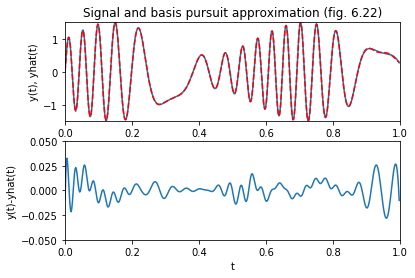

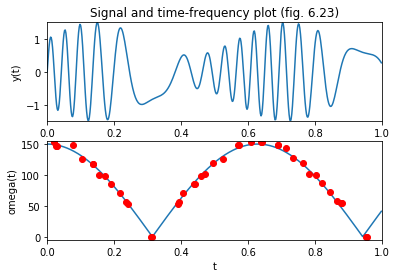

In [24]:
if pylab_installed:
    pylab.figure(2, facecolor='w')
    pylab.subplot(211)
    pylab.plot(ts, y, '-', ts, ybp, 'r--')
    pylab.xlabel('t')
    pylab.ylabel('y(t), yhat(t)')
    pylab.axis([0, 1, -1.5, 1.5])
    pylab.title('Signal and basis pursuit approximation (fig. 6.22)')
    pylab.subplot(212)
    pylab.plot(ts, y-ybp, '-')
    pylab.xlabel('t')
    pylab.ylabel('y(t)-yhat(t)')
    pylab.axis([0, 1, -0.05, 0.05])

    pylab.figure(3, facecolor='w')
    pylab.subplot(211)
    pylab.plot(ts, y, '-')
    pylab.xlabel('t')
    pylab.ylabel('y(t)')
    pylab.axis([0, 1, -1.5, 1.5])
    pylab.title('Signal and time-frequency plot (fig. 6.23)')
    pylab.subplot(212)
    omegas, taus = [], []
    for i in I:
        if i < K:
            omegas += [0.0]
            taus += [i*tau]
        else:
            l = (i-K)/(2*K)+1
            k = ((i-K)%(2*K)) %K
            omegas += [l*omega0]
            taus += [k*tau]
    pylab.plot(ts, 150*abs(cos(5.0*ts)), '-', taus, omegas, 'ro')
    pylab.xlabel('t')
    pylab.ylabel('omega(t)')
    pylab.axis([0, 1, -5, 155])
    pylab.show()